### Dealing with Multi Product Series

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from FinancialMachineLearning.filter.etf_trick import etfTrick

종종 가중치를 시간에 따라 동적으로 조정해야 하는 금융 상품의 시계열을 모델링하고자 할 때가 있다. 또는 때때로 비정기적 쿠폰이나 비정기적 배당 지급 또는 기업 행위와 관련된 상품을 다뤄야만 한다. 연구중인 시계열의 속성을 변경하는 이벤트들을 적절히 다뤄야 한다. 그렇지 않으면 연구 노력이 물거품이 될 수 있는 구조 변화가 예기치 않게 발생할 수 있다. 이 문제는 여러 가지 형태로 발생한다. 그 예로 비중을 변경하면서 스프레드를 모델링할 경우, 주식 바스켓의 배당/쿠폰이 재투자돼야 할 경우, 바스켓을 재조정해야 할 경우, 인덱스 구성이 변경될 경우, 만기 도래한 계약/증권을 다른 것으로 대체해야 할 경우 등을 들 수 있다.

이 중 파생상품인 선물이 적절한 사례라고 할 수 있다. 저자의 경험상, 사람들은 선물을 취급할 때 필요 이상으로 힘들어 한다. 이는 대개 만기 때 적절히 갱신할 수 있는 방법을 잘 모르기 때문이다. 선물의 스프레드나 주식의 바스켓 또는 채권의 전략도 이와 마찬가지라고 할 수 있다. 다음 절에서는 증권의 바스켓을 단일 현금 상품처럼 모델링할 수 있는 방법을 알아본다. Lopez de Prado는 이를 ETF Trick이라 부르는데 이 방법의 목표는 복잡한 복합 상품 데이터셋을 Total Return형 ETF를 따르는 단일 데이터셋으로 변환하는 것이다. 이 방법이 왜 유용한 것일까? 그 이유는 기초 자산의 복잡도나 구성에 상관없이 대개 프로그램 코드를 활용해 항상 현금성 상품만 거래하는 것으로 가정할 수 있다.

In [2]:
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/futures_stitched.csv"
aggregated_df = pd.read_csv(url, index_col = 0, parse_dates = [0])

In [3]:
aggregated_df

,close,open,high,low,volume,ticker,nearest_contract
date,,,,,,,
2021-01-04,255.44,254.60,258.80,254.6,2146.0,G_2021,G_2021
2021-01-05,247.86,251.00,251.00,246.3,3524.0,G_2021,G_2021
2021-01-06,247.38,247.80,248.68,247.2,2614.0,G_2021,G_2021
2021-01-07,255.40,250.00,257.00,250.0,2492.0,G_2021,G_2021
2021-01-08,258.76,259.48,262.30,258.7,1998.0,G_2021,G_2021
...,...,...,...,...,...,...,...
2022-09-23,824.28,850.00,866.00,820.0,2602.0,V_2022,V_2022
2022-09-26,804.00,787.00,816.00,780.0,1846.0,V_2022,V_2022
2022-09-27,831.18,810.00,922.00,808.0,3334.0,V_2022,V_2022


#### 1. ETF Trick

선물 스프레드를 거래하는 전략을 수립한다고 가정해 보자. 완전한 상품 그 자체가 아니라 스프레드를 다뤄야 한다는 것에서 약간의 미묘한 차이가 발생한다. 첫째, 스프레드는 시간에 따라 변동하는 비중 벡터로 특징지을 수 있다. 그 결과 가격은 수렴하지 않아도 스프레드 자체는 수렴할 수 있다. 이런 일이 발생하면 모델은 손익 발생이 비중이 야기한 수렴에 기인한 것으로 오해할 수 있다. 둘째, 스프레드는 가격을 반영하지 않으므로 음의 값을 가질 수 있다. 이는 대부분의 모델이 양의 가격을 가정하므로 문제가 될 수 있다. 셋째, 모든 구성 요소의 거래 시점이 정확히 일치하지 않으므로 스프레드는 가장 최근 가격 레벨에서 항상 거래되는 것이 아니며, 즉시 거래되는 것도 아니다. 또한 매수 매도 크로싱과 같은 거래 실행 비용도 항상 고려해야 한다.

이러한 문제를 해결하는 방법 중 하나는 스프레드에 1달러 가치를 투자한다고 가정한 시계열 데이터를 생성하는 것이다. 시계열의 변화는 손익의 변화를 반영할 것이고, 시계열은 항상 양수이고, 거래 집행 비용도 고려될 것이다. 이는 마치 ETF인 것처럼 모델링하고, 신호를 생성하고, 거래하고자 사용되는 시계열이다.

2.3절에서 설명한 여러 기법에서 도출한 바들로 구성된 history가 주어졌다고 가정해보자. 이들 바는 다음의 열을 포함한다.

- $o_{i,t}$는 금융 상품 $i$의 open price이다. 여기서 바가 $t = 1,\dots, T$일 때, $i = 1,\dots, I$이다.
- $p_{i,t}$는 금융 상품 $i$의 close price이다. 여기서 바가 $t = 1,\dots, T$일 때, $i = 1,\dots, I$이다.
- $\varphi_{i,t}$는 금융 상품 $i$의 시점 당 거래대금이다. 여기서 바가 $t = 1,\dots, T$일 때, $i = 1,\dots, I$이다. 이는 환율을 포함한다.
- $\nu_{i,t}$는 금융 상품 $i$의 거래량이다. 여기서 바가 $t = 1,\dots, T$일 때, $i = 1,\dots, I$이다.
- $d_{i,t}$는 바 $t$에서의 캐리, 배당 또는 쿠폰에 의한 가치이다. 이 변수는 한계 비용이나 조달 비용을 부과할 때에도 이용할 수 있다.

여기서 모든 금융 상품 $i = 1,\dots, I$는 바 $t = 1,\dots, T$에서 거래가 가능하다. 다시 말해 어떤 금융 상품이 시간 $[t-1, t]$ 전체에 걸쳐 항상 거래되는 일은 불가능하더라도 적어도 시점 $t-1$과 $t$에서는 거래 가능하다. 바 $B \subseteq \{1,\dots, T\}$에 재조정된 배분 벡터 $\nu_t$로 특징지어진 선물 바스켓의 1달러 투자 가치 $\{K_t\}$는 다음과 같이 유도할 수 있다.

$$
h_{i,t} =
\begin{cases}
\frac{\omega_{i,t} K_t}{o_{i,t+1} \varphi_{i,t} \sum_{i=1}^I \left\vert \omega_{i,t}\right\vert} &\text{ if } t \in B \\
h_{i, t-1} & \text{ else }
\end{cases}
$$
$$
\delta_{i,t} =
\begin{cases}
p_{i,t} - o_{i,t} &\text{ if } (t-1) \in B \\
\Delta p_{i,t} & \text{ else }
\end{cases}
$$
$$K_t = K_{t-1} + \sum_{i=1}^I h_{i,t-1} \varphi_{i,t}(\delta_{i,t} + d_{i,t})$$

그리고 최초 운용 자산(AUM)에서 $K_0 = 1$이다. 변수 $h_{i,t}$는 시간 $t$에서의 금융 상품 $i$의 보유 자산을 나타낸다. 변수 $\delta_{i,t}$는 금융 상품 $i$의 시점 $t-1$과 $t$ 사이의 시장 가격 변동을 의미한다. $t \in B$일 때마다 수익이나 손실은 재투자돼 음수 가격을 방지한다는 점에 주목하자. 배당금 $d_{i,t}$는 이미 $K_t$에 내포돼 있으므로 전략에 있어 별도로 고려할 필요 없다.

#### 2. PCA Weights

관심 있는 사람들은 'Lopez de Prado Leinweber, 2012'와 'Bailey and Lopez de Prado, 2012'에서 헤지 비중을 산출하는 여러 실질적인 계산 방법을 찾아볼 수 있다. 앞의 토론을 완결하는 차원에서 배분 벡터 $\{\omega_t\}$를 도출하는 방법 중 하나를 살펴보자. 크기가 $N \times 1$이고 평균이 $\mu$ 벡터에 의해 특징지어지는 IID 다변량 가우시안 프로세스를 고려해 보자. 공분산 행렬 크기가 $N \times N$이다. 이 확률 프로세스는 주식의 수익률, 채권의 수익률 변화, 옵션의 변동성 변화 등과 같이 $N$개 자산으로 구성된 포트폴리오의 확률 변수를 기술하는데, 여기서 이들은 시간에 따라 변하지 않는다. 여기서는 $V$ 주성분 요인에 걸쳐 있는 특정 리스트의 분산에 상응하는 배분 벡터 $\omega$를 계산하고자 한다.

첫째, 스펙트럼 분해 $VW = W\Lambda$를 수행한다. 여기서 $W$의 열을 $\Lambda$의 대각 원소가 내림차순으로 정렬되도록 재정렬한다. 둘째, 벡터 정렬 $\omega$가 주어지면 포트폴리오의 리스크는 $\sigma^2 = \omega^\prime V \omega = \omega^\prime W \Lambda W^\prime \omega = \beta^\prime \Lambda \beta = \left( \Lambda^{\frac{1}{2}} \beta \right)^\prime \left( \Lambda^{\frac{1}{2}} \beta \right)$로 계산할 수 있다. 여기서 $\beta$는 $\omega$가 직교 기저에서의 projection을 나타낸다. 셋째, $\Lambda$는 대각 행렬이므로 $\sigma^2 = \sum_{n=1}^N \beta_n^2 \Lambda_{n,n}$이고, $n$번째 성분에 해당되는 리스크는 $R_n = \beta_n^2 \Lambda_{n,n} \sigma^{-2} = \left[ W^\prime \omega \right]_n^2 \Lambda_{n,n} \sigma^{-2}$이며, $R^\prime 1_N = 1$이고, $1_N$은 $N$개의 1을 가진 벡터이다. $\{R\}_{n = 1, \dots, N}$은 직교 성분에 따른 리스크 분포로 해석할 수 있다. 넷째, 사용자 정의 리스크 분포 $R$을 산출하는 벡터 $\omega$를 계산하고자 한다. 이전 단계에서 $\beta = \left\{ \sigma \sqrt{\frac{R_n}{\Lambda_{n,n}}}\right\}_{n = 1, \dots, N}$이고, 이는 새로운 기저에서의 배분을 나타낸다. 다섯째, 이전 기저에서의 배분은 $\omega = W\beta$에 의해 나타난다. $\nu$를 크기 조정하는 것은 단순히 $\sigma$를 조정하는 것이므로 리스크 분포는 일정하게 유지된다. 아래의 그림은 역분산 배분에 따른 주성분별 리스크 기여를 나타낸다.

#### 3. Single Future Roll

ETF Trick을 사용하면 단일 선물 계열의 roll은 1-lag spread의 특별한 경우로 간주해 다룰 수 있다. 그러나 단일 선물 계약을 취급할 때 동일하지만 보다 직접적인 방법은 cumulative roll gap 시계열을 형성한 후 그 갭 시계열만큼을 가격 시계열에서 차감하는 것이다. 아래의 코드는 이러한 로직을 구현하는 예를 보여 주는데, 블룸버그에서 다운로드하고 $\text{HDF5}$ 형식의 표에 저장된 틱 바의 계열을 사용한다. 블룸버그 필드는 각각 다음과 같은 의미이다.

- `FUT_CUR_GEN_TICKER` : 그 가격에 연계된 계약을 식별한다. 이 값은 각 롤 오버마다 변한다.
- `PX_OPEN` : 바와 연계된 시가이다.
- `PX_LAST` : 바와 연계된 종가이다.
- `VWAP` : 바와 연계된 거래량 가중값 평균 가격이다.

In [9]:
etf_trick = etfTrick.get_futures_roll_series(
    aggregated_df,
    open_col = 'open',
    close_col = 'close',
    sec_col = 'ticker',
    current_sec_col = 'nearest_contract',
    roll_backward = False
)

In [10]:
etf_trick

date
2021-01-04    0.00
2021-01-05    0.00
2021-01-06    0.00
2021-01-07    0.00
2021-01-08    0.00
              ... 
2022-09-23   -4.08
2022-09-26   -4.08
2022-09-27   -4.08
2022-09-28   -4.08
2022-09-29   -4.08
Name: close, Length: 450, dtype: float64

In [15]:
adjusted_close = aggregated_df['close'] + etf_trick

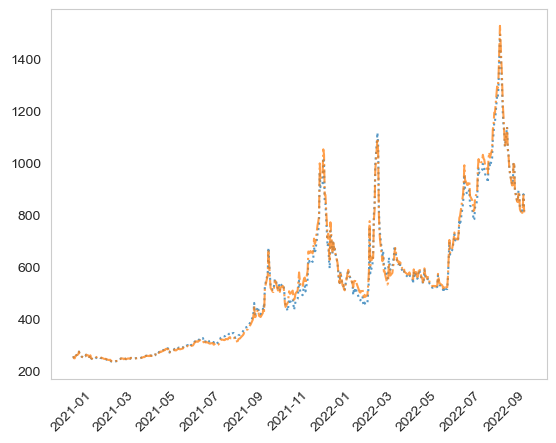

In [25]:
plt.plot(aggregated_df['close'], ls = ':', alpha = 0.75)
plt.plot(adjusted_close, ls = '-.', alpha = 0.75)
plt.grid(False)
plt.xticks(rotation = 45)
plt.show()